In [207]:
import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import pandas
import matplotlib.dates as mdates

In [208]:

directory = "/Work/Stock Market Predictions ML, LSTM and Statistical Analysis/"
filenames = [x for x in os.listdir(directory) if x.endswith(('AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv', 'TSLA.csv', 'INTC.csv')) and os.path.getsize(os.path.join(directory, x)) > 0]
txt_files = [x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(os.path.join('', x)) > 0]
filenames_txt = random.sample(txt_files, min(8, len(txt_files)))
print(filenames)
print(filenames_txt)



['AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'INTC.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv', 'TSLA.csv']
[]


In [209]:
data = []
for filename in filenames:
    df = pd.read_csv(os.path.join(directory, filename), sep=',')
    label, _ = filename.split(sep='.')
    df['Label'] = label
    df['Date'] = pd.to_datetime(df['Date'])
    data.append(df)

In [210]:

data = []

for filename in filenames:
    df = pd.read_csv(os.path.join('',filename), sep=',')
    
    label = filename.split('.')[0]
    
    df['Label'] = label
    df['Date'] = pd.to_datetime(df['Date'])
    
    data.append(df)

In [211]:
data[0].head()

Date      Open      High       Low     Close  Adj Close     Volume   
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099584  469033600  \
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094388  175884800   
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087461  105728000   
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089625   86441600   
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092224   73449600   

  Label  
0  AAPL  
1  AAPL  
2  AAPL  
3  AAPL  
4  AAPL

In [212]:
def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)

In [213]:
def rsi(series):
    delta = series.diff().dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)   
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

TechIndicator = [
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/AAPL.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/AMZN.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/GOOG.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/META.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/MSFT.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/NVDA.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/TSLA.csv"),
    pd.read_csv("../Stock Market Predictions ML, LSTM and Statistical Analysis/INTC.csv"),

]

for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Momentum_1D'] = (TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(1)).fillna(0)
    TechIndicator[stock]['RSI_14D'] = rsi(TechIndicator[stock]['Momentum_1D']).fillna(0)
print(TechIndicator[0].tail(5))

            Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume  Momentum_1D    RSI_14D  
10734  41342300     0.769989  46.247922  
10735  41573900     0.150009  50.854266  
10736  50520200     3.300003  57.964153  
10737  48353800    -0.260009  44.728646  
10738  80507300     1.370010  50.310787  


In [214]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Volume_plain'] = TechIndicator[stock]['Volume'].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume  Momentum_1D    RSI_14D  Volume_plain  
10734  41342300     0.769989  46.247922      41342300  
10735  41573900     0.150009  50.854266      41573900  
10736  50520200     3.300003  57.964153      50520200  
10737  48353800    -0.260009  44.728646      48353800  
10738  80507300     1.370010  50.310787      80507300

In [215]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [216]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['BB_Middle_Band'], TechIndicator[stock]['BB_Upper_Band'], TechIndicator[stock]['BB_Lower_Band'] = bbands(TechIndicator[stock]['Close'], length=20, numsd=1)
    TechIndicator[stock]['BB_Middle_Band'] = TechIndicator[stock]['BB_Middle_Band'].fillna(0)
    TechIndicator[stock]['BB_Upper_Band'] = TechIndicator[stock]['BB_Upper_Band'].fillna(0)
    TechIndicator[stock]['BB_Lower_Band'] = TechIndicator[stock]['BB_Lower_Band'].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume  Momentum_1D    RSI_14D  Volume_plain  BB_Middle_Band   
10734  41342300     0.769989  46.247922      41342300         188.347  \
10735  41573900     0.150009  50.854266      41573900         188.684   
10736  50520200     3.300003  57.964153      50520200         189.083   
10737  48353800    -0.260009  44.728646      48353800         189.524   
10738  80507300     1.370010  50.310787      80507300         190.029   

       BB_Upper_Band  BB_Lower_Band  
10734        191.297        185.398  
10735        191.486        185.883  
10736        192.048        186.119  
10737        192.492        186.556  
10738        193.046        187.011

In [217]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [218]:
for stock in range(len(TechIndicator)):
    listofzeros = [0] * 25
    up, down = aroon(TechIndicator[stock])
    aroon_list = [x - y for x, y in zip(up,down)]
    if len(aroon_list)==0:
        aroon_list = [0] * TechIndicator[stock].shape[0]
        TechIndicator[stock]['Aroon_Oscillator'] = aroon_list
    else:
        TechIndicator[stock]['Aroon_Oscillator'] = listofzeros+aroon_list

In [219]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]["PVT"] = (TechIndicator[stock]['Momentum_1D']/ TechIndicator[stock]['Close'].shift(1))*TechIndicator[stock]['Volume']
    TechIndicator[stock]["PVT"] = TechIndicator[stock]["PVT"]-TechIndicator[stock]["PVT"].shift(1)
    TechIndicator[stock]["PVT"] = TechIndicator[stock]["PVT"].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume  Momentum_1D    RSI_14D  Volume_plain  BB_Middle_Band   
10734  41342300     0.769989  46.247922      41342300         188.347  \
10735  41573900     0.150009  50.854266      41573900         188.684   
10736  50520200     3.300003  57.964153      50520200         189.083   
10737  48353800    -0.260009  44.728646      48353800         189.524   
10738  80507300     1.370010  50.310787      80507300         190.029   

       BB_Upper_Band  BB_Lower_Band  Aroon_Oscillator            PVT  
10734        191.297        185.398              64.0 -378128.100826  
10735        191.486        185.883              64.0 -135015.327047  
10736        192.048        186.119              60.0  841551.422994  
10737        192.492        186.556              56.0 -939091.514220  
10738        193.046        187.011              52.0  634137.101652

In [220]:
def abands(df):
    df['AB_Middle_Band'] = df['Close'].rolling(window = 20, center=False).mean()
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Upper_Band'] = df['aupband'].rolling(window=20, center=False).mean()
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Lower_Band'] = df['adownband'].rolling(window=20, center=False).mean()

In [221]:
for stock in range(len(TechIndicator)):
    abands(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume  Momentum_1D    RSI_14D  Volume_plain  BB_Middle_Band   
10734  41342300     0.769989  46.247922      41342300         188.347  \
10735  41573900     0.150009  50.854266      41573900         188.684   
10736  50520200     3.300003  57.964153      50520200         189.083   
10737  48353800    -0.260009  44.728646      48353800         189.524   
10738  80507300     1.370010  50.310787      80507300         190.029   

       BB_Upper_Band  BB_Lower_Band  Aroon_Oscillator            PVT   
10734        191.297        185.398              64.0 -378128.100826  \
10735        191.486        185.883              64.0 -135015.327047   
10736        192.048        186.119              60.0  841551.422994   
10737        192.492        186.556              56.0 -939091.514220   
10738        193.046        187.011              52.0  634137.101652   

       AB_Middle_Band     aupband  AB_Upper_Band   adownband  AB_Lower_Band  
10734      188.347499  194.020445     194.515611  186.970430     181.895601  
10735      188.684499  194.292587     194.772208  186.542647     182.357200  
10736      189.083500  199.372657     195.138813  186.822612     182.781303  
10737      189.524000  198.168875     195.423763  188.618855     183.268753  
10738      190.028500  209.549314     196.426458  181.649304     183.298948

In [222]:
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)
TechIndicator[0].head()

Date      Open      High       Low     Close  Adj Close     Volume   
0  12/12/1980  0.128348  0.128906  0.128348  0.128348   0.099584  469033600  \
1  12/15/1980  0.122210  0.122210  0.121652  0.121652   0.094388  175884800   
2  12/16/1980  0.113281  0.113281  0.112723  0.112723   0.087461  105728000   
3  12/17/1980  0.115513  0.116071  0.115513  0.115513   0.089625   86441600   
4  12/18/1980  0.118862  0.119420  0.118862  0.118862   0.092224   73449600   

     RSI_14D  Volume_plain  BB_Middle_Band  BB_Upper_Band  BB_Lower_Band   
0   0.000000     469033600             0.0            0.0            0.0  \
1   0.000000     175884800             0.0            0.0            0.0   
2   0.000000     105728000             0.0            0.0            0.0   
3  56.756102      86441600             0.0            0.0            0.0   
4  57.895978      73449600             0.0            0.0            0.0   

   Aroon_Oscillator           PVT  AB_Middle_Band  AB_Upper_Band   
0               0.0  0.000000e+00             0.0            0.0  \
1               0.0  0.000000e+00             0.0            0.0   
2               0.0  1.415814e+06             0.0            0.0   
3               0.0  9.899723e+06             0.0            0.0   
4               0.0 -1.002994e+04             0.0            0.0   

   AB_Lower_Band  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [223]:
def STOK(df, n):
    df['STOK'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

In [224]:
for stock in range(len(TechIndicator)):
    STOK(TechIndicator[stock], 4)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume    RSI_14D  Volume_plain  BB_Middle_Band  BB_Upper_Band   
10734  41342300  46.247922      41342300         188.347        191.297  \
10735  41573900  50.854266      41573900         188.684        191.486   
10736  50520200  57.964153      50520200         189.083        192.048   
10737  48353800  44.728646      48353800         189.524        192.492   
10738  80507300  50.310787      80507300         190.029        193.046   

       BB_Lower_Band  Aroon_Oscillator            PVT  AB_Middle_Band   
10734        185.398              64.0 -378128.100826      188.347499  \
10735        185.883              64.0 -135015.327047      188.684499   
10736        186.119              60.0  841551.422994      189.083500   
10737        186.556              56.0 -939091.514220      189.524000   
10738        187.011              52.0  634137.101652      190.028500   

       AB_Upper_Band  AB_Lower_Band       STOK       STOD  
10734     194.515611     181.895601  50.343094  24.977113  
10735     194.772208     182.357200  40.588292  39.549918  
10736     195.138813     182.781303  69.529916  53.487101  
10737     195.423763     183.268753  59.999953  56.706054  
10738     196.426458     183.298948  40.378034  56.635968

In [225]:
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['Date']):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [226]:
for stock in range(len(TechIndicator)):
    listofzeros = [0] * 40
    CHMF = CMFlow(TechIndicator[stock], 20)
    if len(CHMF)==0:
        CHMF = [0] * TechIndicator[stock].shape[0]
        TechIndicator[stock]['Chaikin_MF'] = CHMF
    else:
        TechIndicator[stock]['Chaikin_MF'] = listofzeros+CHMF
TechIndicator[0].tail()

C:\Users\User_Win10x64\AppData\Local\Temp\ipykernel_11732\299586020.py:13: RuntimeWarning: invalid value encountered in scalar divide
  MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
C:\Users\User_Win10x64\AppData\Local\Temp\ipykernel_11732\299586020.py:13: RuntimeWarning: invalid value encountered in scalar divide
  MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])


Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume    RSI_14D  Volume_plain  BB_Middle_Band  BB_Upper_Band   
10734  41342300  46.247922      41342300         188.347        191.297  \
10735  41573900  50.854266      41573900         188.684        191.486   
10736  50520200  57.964153      50520200         189.083        192.048   
10737  48353800  44.728646      48353800         189.524        192.492   
10738  80507300  50.310787      80507300         190.029        193.046   

       BB_Lower_Band  Aroon_Oscillator            PVT  AB_Middle_Band   
10734        185.398              64.0 -378128.100826      188.347499  \
10735        185.883              64.0 -135015.327047      188.684499   
10736        186.119              60.0  841551.422994      189.083500   
10737        186.556              56.0 -939091.514220      189.524000   
10738        187.011              52.0  634137.101652      190.028500   

       AB_Upper_Band  AB_Lower_Band       STOK       STOD  Chaikin_MF  
10734     194.515611     181.895601  50.343094  24.977113    2.653082  
10735     194.772208     182.357200  40.588292  39.549918    2.715806  
10736     195.138813     182.781303  69.529916  53.487101    2.364364  
10737     195.423763     183.268753  59.999953  56.706054    2.381626  
10738     196.426458     183.298948  40.378034  56.635968    3.385671

In [227]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    df['psar'] = psar

In [228]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['VWAP'] = np.cumsum(TechIndicator[stock]['Volume'] * (TechIndicator[stock]['High'] + TechIndicator[stock]['Low'])/2) / np.cumsum(TechIndicator[stock]['Volume'])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume    RSI_14D  Volume_plain  BB_Middle_Band  ...  BB_Lower_Band   
10734  41342300  46.247922      41342300         188.347  ...        185.398  \
10735  41573900  50.854266      41573900         188.684  ...        185.883   
10736  50520200  57.964153      50520200         189.083  ...        186.119   
10737  48353800  44.728646      48353800         189.524  ...        186.556   
10738  80507300  50.310787      80507300         190.029  ...        187.011   

       Aroon_Oscillator            PVT  AB_Middle_Band  AB_Upper_Band   
10734              64.0 -378128.100826      188.347499     194.515611  \
10735              64.0 -135015.327047      188.684499     194.772208   
10736              60.0  841551.422994      189.083500     195.138813   
10737              56.0 -939091.514220      189.524000     195.423763   
10738              52.0  634137.101652      190.028500     196.426458   

       AB_Lower_Band       STOK       STOD  Chaikin_MF      VWAP  
10734     181.895601  50.343094  24.977113    2.653082  9.138171  
10735     182.357200  40.588292  39.549918    2.715806  9.140335  
10736     182.781303  69.529916  53.487101    2.364364  9.143003  
10737     183.268753  59.999953  56.706054    2.381626  9.145561  
10738     183.298948  40.378034  56.635968    3.385671  9.149868  

[5 rows x 21 columns]

In [229]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Momentum'] = TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(4)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date        Open        High         Low       Close   Adj Close   
10734  7/13/2023  190.500000  191.190002  189.779999  190.539993  190.539993  \
10735  7/14/2023  190.229996  191.179993  189.630005  190.690002  190.690002   
10736  7/17/2023  191.899994  194.320007  191.809998  193.990005  193.990005   
10737  7/18/2023  193.350006  194.330002  192.419998  193.729996  193.729996   
10738  7/19/2023  193.100006  198.229996  192.649994  195.100006  195.100006   

         Volume    RSI_14D  Volume_plain  BB_Middle_Band  ...   
10734  41342300  46.247922      41342300         188.347  ...  \
10735  41573900  50.854266      41573900         188.684  ...   
10736  50520200  57.964153      50520200         189.083  ...   
10737  48353800  44.728646      48353800         189.524  ...   
10738  80507300  50.310787      80507300         190.029  ...   

       Aroon_Oscillator            PVT  AB_Middle_Band  AB_Upper_Band   
10734              64.0 -378128.100826      188.347499     194.515611  \
10735              64.0 -135015.327047      188.684499     194.772208   
10736              60.0  841551.422994      189.083500     195.138813   
10737              56.0 -939091.514220      189.524000     195.423763   
10738              52.0  634137.101652      190.028500     196.426458   

       AB_Lower_Band       STOK       STOD  Chaikin_MF      VWAP  Momentum  
10734     181.895601  50.343094  24.977113    2.653082  9.138171 -0.140000  
10735     182.357200  40.588292  39.549918    2.715806  9.140335  2.080001  
10736     182.781303  69.529916  53.487101    2.364364  9.143003  5.910003  
10737     183.268753  59.999953  56.706054    2.381626  9.145561  3.959992  
10738     183.298948  40.378034  56.635968    3.385671  9.149868  4.560013  

[5 rows x 22 columns]

In [230]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / (constant * TP.rolling(window=n, center=False).std())) #, name = 'CCI_' + str(n))
    return CCI

In [231]:
for stock in range(len(TechIndicator)):
    new = (TechIndicator[stock]['Volume'] * (~TechIndicator[stock]['Close'].diff().le(0) * 2 -1)).cumsum()
    TechIndicator[stock]['OBV'] = new
TechIndicator[5].tail()

Date        Open        High         Low       Close   Adj Close   
6157  7/13/2023  445.179993  461.549988  444.920013  459.769989  459.769989  \
6158  7/14/2023  465.829987  480.880005  450.600006  454.690002  454.690002   
6159  7/17/2023  462.890015  464.959991  452.619995  464.609985  464.609985   
6160  7/18/2023  467.010010  478.959991  457.339996  474.940002  474.940002   
6161  7/19/2023  474.640015  478.179993  467.420013  470.769989  470.769989   

        Volume    RSI_14D  Volume_plain  BB_Middle_Band  ...           PVT   
6157  47820400  57.456051      47820400         425.489  ...  5.611753e+05  \
6158  77066400  50.972473      77066400         426.725  ... -3.111705e+06   
6159  51048800  57.749616      51048800         428.629  ...  1.965238e+06   
6160  57019000  49.235235      57019000         431.030  ...  1.540126e+05   
6161  42750200  51.291339      42750200         432.664  ... -1.643096e+06   

      AB_Middle_Band  AB_Upper_Band  AB_Lower_Band       STOK       STOD   
6157      425.489000     456.624901     393.254882  71.698822  59.788742  \
6158      426.725000     459.775608     394.955592  31.057963  59.532929   
6159      428.628999     461.472436     396.422424  38.848575  47.201786   
6160      431.029999     464.698850     396.893841  65.545063  45.150533   
6161      432.664499     466.365107     399.160105  45.492031  49.961890   

      Chaikin_MF       VWAP   Momentum          OBV  
6157    2.536017  27.354874  34.739990  12603050900  
6158    2.188078  27.444453  32.890014  12525984500  
6159    0.104743  27.502828  40.559997  12577033300  
6160    1.222512  27.569427  35.920013  12634052300  
6161    3.170278  27.619874  11.000000  12591302100  

[5 rows x 23 columns]

In [232]:
def KELCH(df, n):  
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

In [233]:
for stock in range(len(TechIndicator)):
    KelchM, KelchD, KelchU = KELCH(TechIndicator[stock], 14)
    TechIndicator[stock]['Kelch_Upper'] = KelchU
    TechIndicator[stock]['Kelch_Middle'] = KelchM
    TechIndicator[stock]['Kelch_Down'] = KelchD
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[5].tail()

Date        Open        High         Low       Close   Adj Close   
6157  7/13/2023  445.179993  461.549988  444.920013  459.769989  459.769989  \
6158  7/14/2023  465.829987  480.880005  450.600006  454.690002  454.690002   
6159  7/17/2023  462.890015  464.959991  452.619995  464.609985  464.609985   
6160  7/18/2023  467.010010  478.959991  457.339996  474.940002  474.940002   
6161  7/19/2023  474.640015  478.179993  467.420013  470.769989  470.769989   

        Volume    RSI_14D  Volume_plain  BB_Middle_Band  ...  AB_Lower_Band   
6157  47820400  57.456051      47820400         425.489  ...     393.254882  \
6158  77066400  50.972473      77066400         426.725  ...     394.955592   
6159  51048800  57.749616      51048800         428.629  ...     396.422424   
6160  57019000  49.235235      57019000         431.030  ...     396.893841   
6161  42750200  51.291339      42750200         432.664  ...     399.160105   

           STOK       STOD  Chaikin_MF       VWAP   Momentum          OBV   
6157  71.698822  59.788742    2.536017  27.354874  34.739990  12603050900  \
6158  31.057963  59.532929    2.188078  27.444453  32.890014  12525984500   
6159  38.848575  47.201786    0.104743  27.502828  40.559997  12577033300   
6160  65.545063  45.150533    1.222512  27.569427  35.920013  12634052300   
6161  45.492031  49.961890    3.170278  27.619874  11.000000  12591302100   

      Kelch_Upper  Kelch_Middle  Kelch_Down  
6157   435.080477    423.184047  411.287617  
6158   439.434287    425.942143  412.449999  
6159   441.918332    429.447618  416.976904  
6160   446.411190    433.461903  420.512617  
6161   450.554996    437.784998  425.015000  

[5 rows x 26 columns]

In [234]:
def ATR(df, period):
    df['High-Low'] = df['High'] - df['Low']
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=period, min_periods=1).mean()
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TR'], axis=1, inplace=True)

def DMI(df, period):
    ATR(df, period)  # Calculate ATR first
    
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * (df['PlusDM'] / df['ATR']).ewm(span=period, min_periods=0, adjust=True, ignore_na=False).mean()
    df['minusDI'] = 100 * (df['MinusDM'] / df['ATR']).ewm(span=period, min_periods=0, adjust=True, ignore_na=False).mean()

    df['ADX'] = 100 * (abs((df['plusDI'] - df['minusDI']) / (df['plusDI'] + df['minusDI']))).ewm(span=period, min_periods=0, adjust=True, ignore_na=False).mean()


In [235]:
for stock in range(len(TechIndicator)):
    DMI(TechIndicator[stock], 14)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
print(TechIndicator[5].tail())

           Date        Open        High         Low       Close   Adj Close   
6157  7/13/2023  445.179993  461.549988  444.920013  459.769989  459.769989  \
6158  7/14/2023  465.829987  480.880005  450.600006  454.690002  454.690002   
6159  7/17/2023  462.890015  464.959991  452.619995  464.609985  464.609985   
6160  7/18/2023  467.010010  478.959991  457.339996  474.940002  474.940002   
6161  7/19/2023  474.640015  478.179993  467.420013  470.769989  470.769989   

        Volume    RSI_14D  Volume_plain  BB_Middle_Band  ...  Kelch_Down   
6157  47820400  57.456051      47820400         425.489  ...  411.287617  \
6158  77066400  50.972473      77066400         426.725  ...  412.449999   
6159  51048800  57.749616      51048800         428.629  ...  416.976904   
6160  57019000  49.235235      57019000         431.030  ...  420.512617   
6161  42750200  51.291339      42750200         432.664  ...  425.015000   

            ATR     UpMove   DownMove  Zero     PlusDM  MinusDM     

In [236]:
for stock in range(len(TechIndicator)):
    if 'Year' in TechIndicator[stock].columns:
        TechIndicator[stock].index = pd.to_datetime(TechIndicator[stock]['Year'])
        TechIndicator[stock] = TechIndicator[stock].drop(labels=['Year'], axis=1)
    else:
        print(f"The DataFrame at index {stock} does not contain a 'Year' column.")

The DataFrame at index 0 does not contain a 'Year' column.
The DataFrame at index 1 does not contain a 'Year' column.
The DataFrame at index 2 does not contain a 'Year' column.
The DataFrame at index 3 does not contain a 'Year' column.
The DataFrame at index 4 does not contain a 'Year' column.
The DataFrame at index 5 does not contain a 'Year' column.
The DataFrame at index 6 does not contain a 'Year' column.
The DataFrame at index 7 does not contain a 'Year' column.


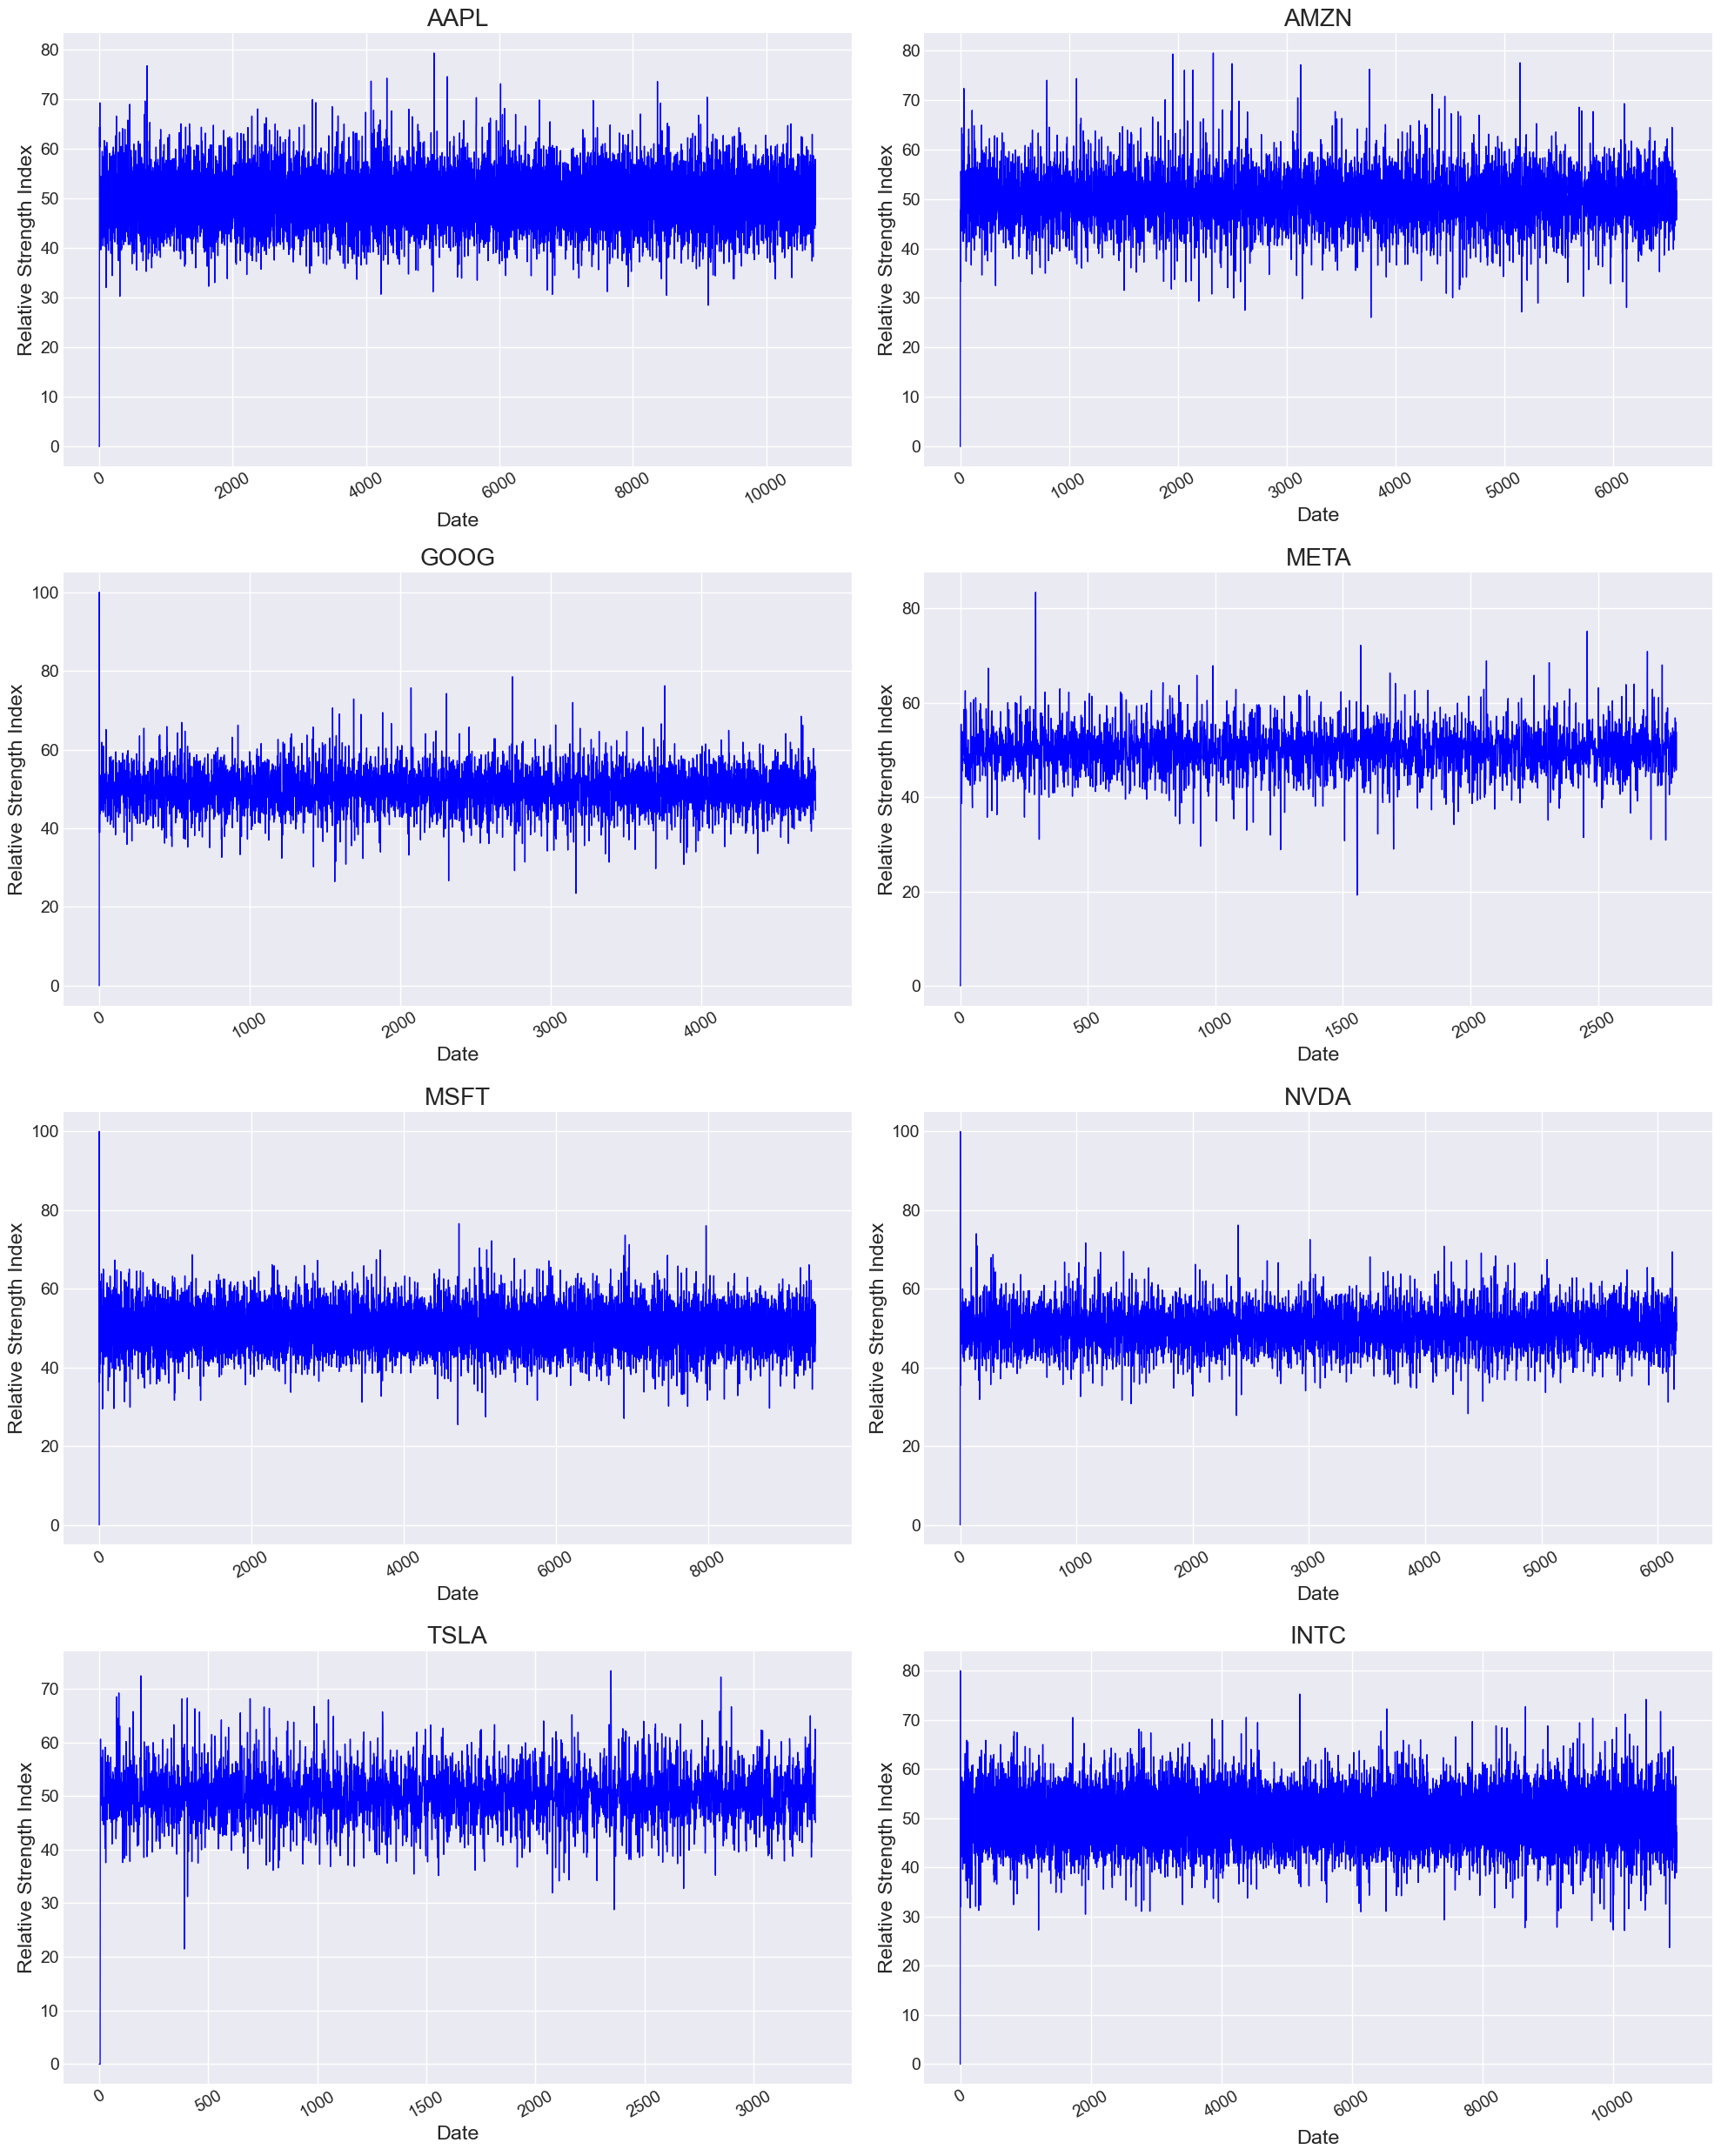

In [237]:
stock_names = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA', 'INTC']
for i in range(len(TechIndicator)):
    TechIndicator[i]['Label'] = stock_names[i]
fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['RSI_14D'], color='blue', linewidth=1)
    ax.set_title(str(TechIndicator[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Relative Strength Index")
    plt.xticks(rotation=30)
fig.tight_layout()

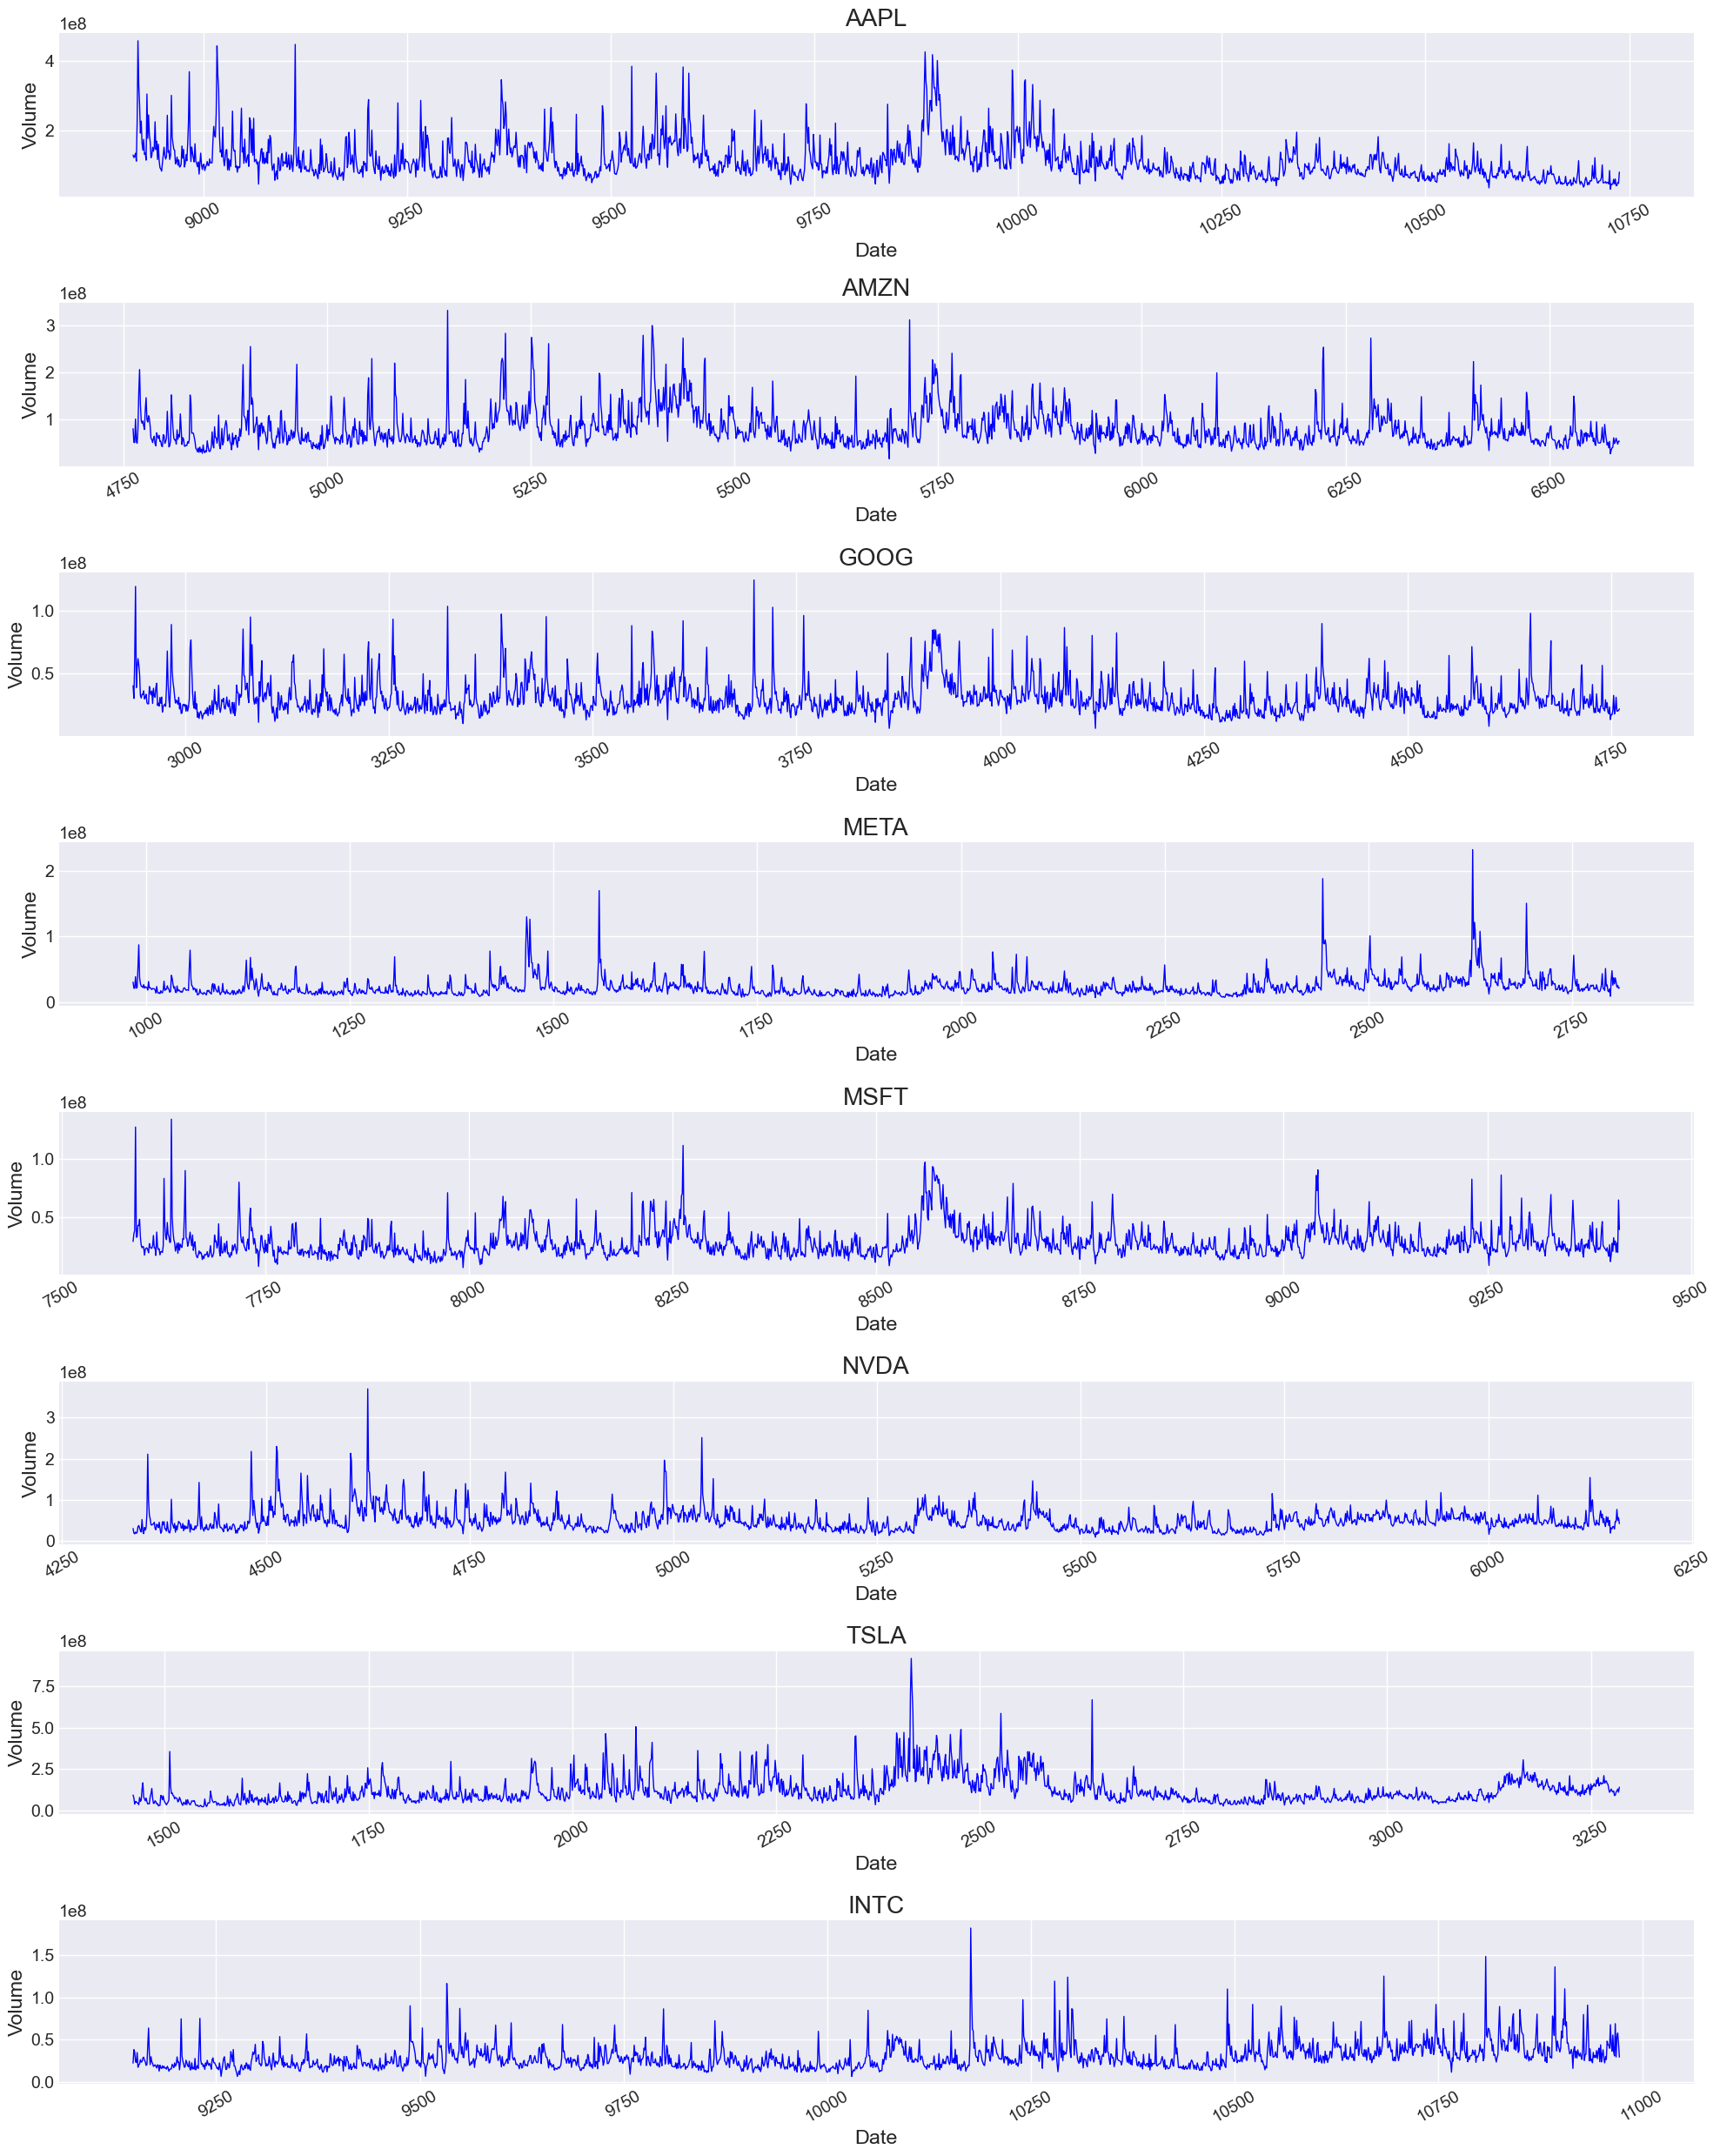

In [238]:
fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(8,1,i+1)
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['Volume_plain'][-1825:], 'b', linewidth=1)
    ax.set_title(str(TechIndicator[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Volume")
    plt.xticks(rotation=30)
fig.tight_layout()

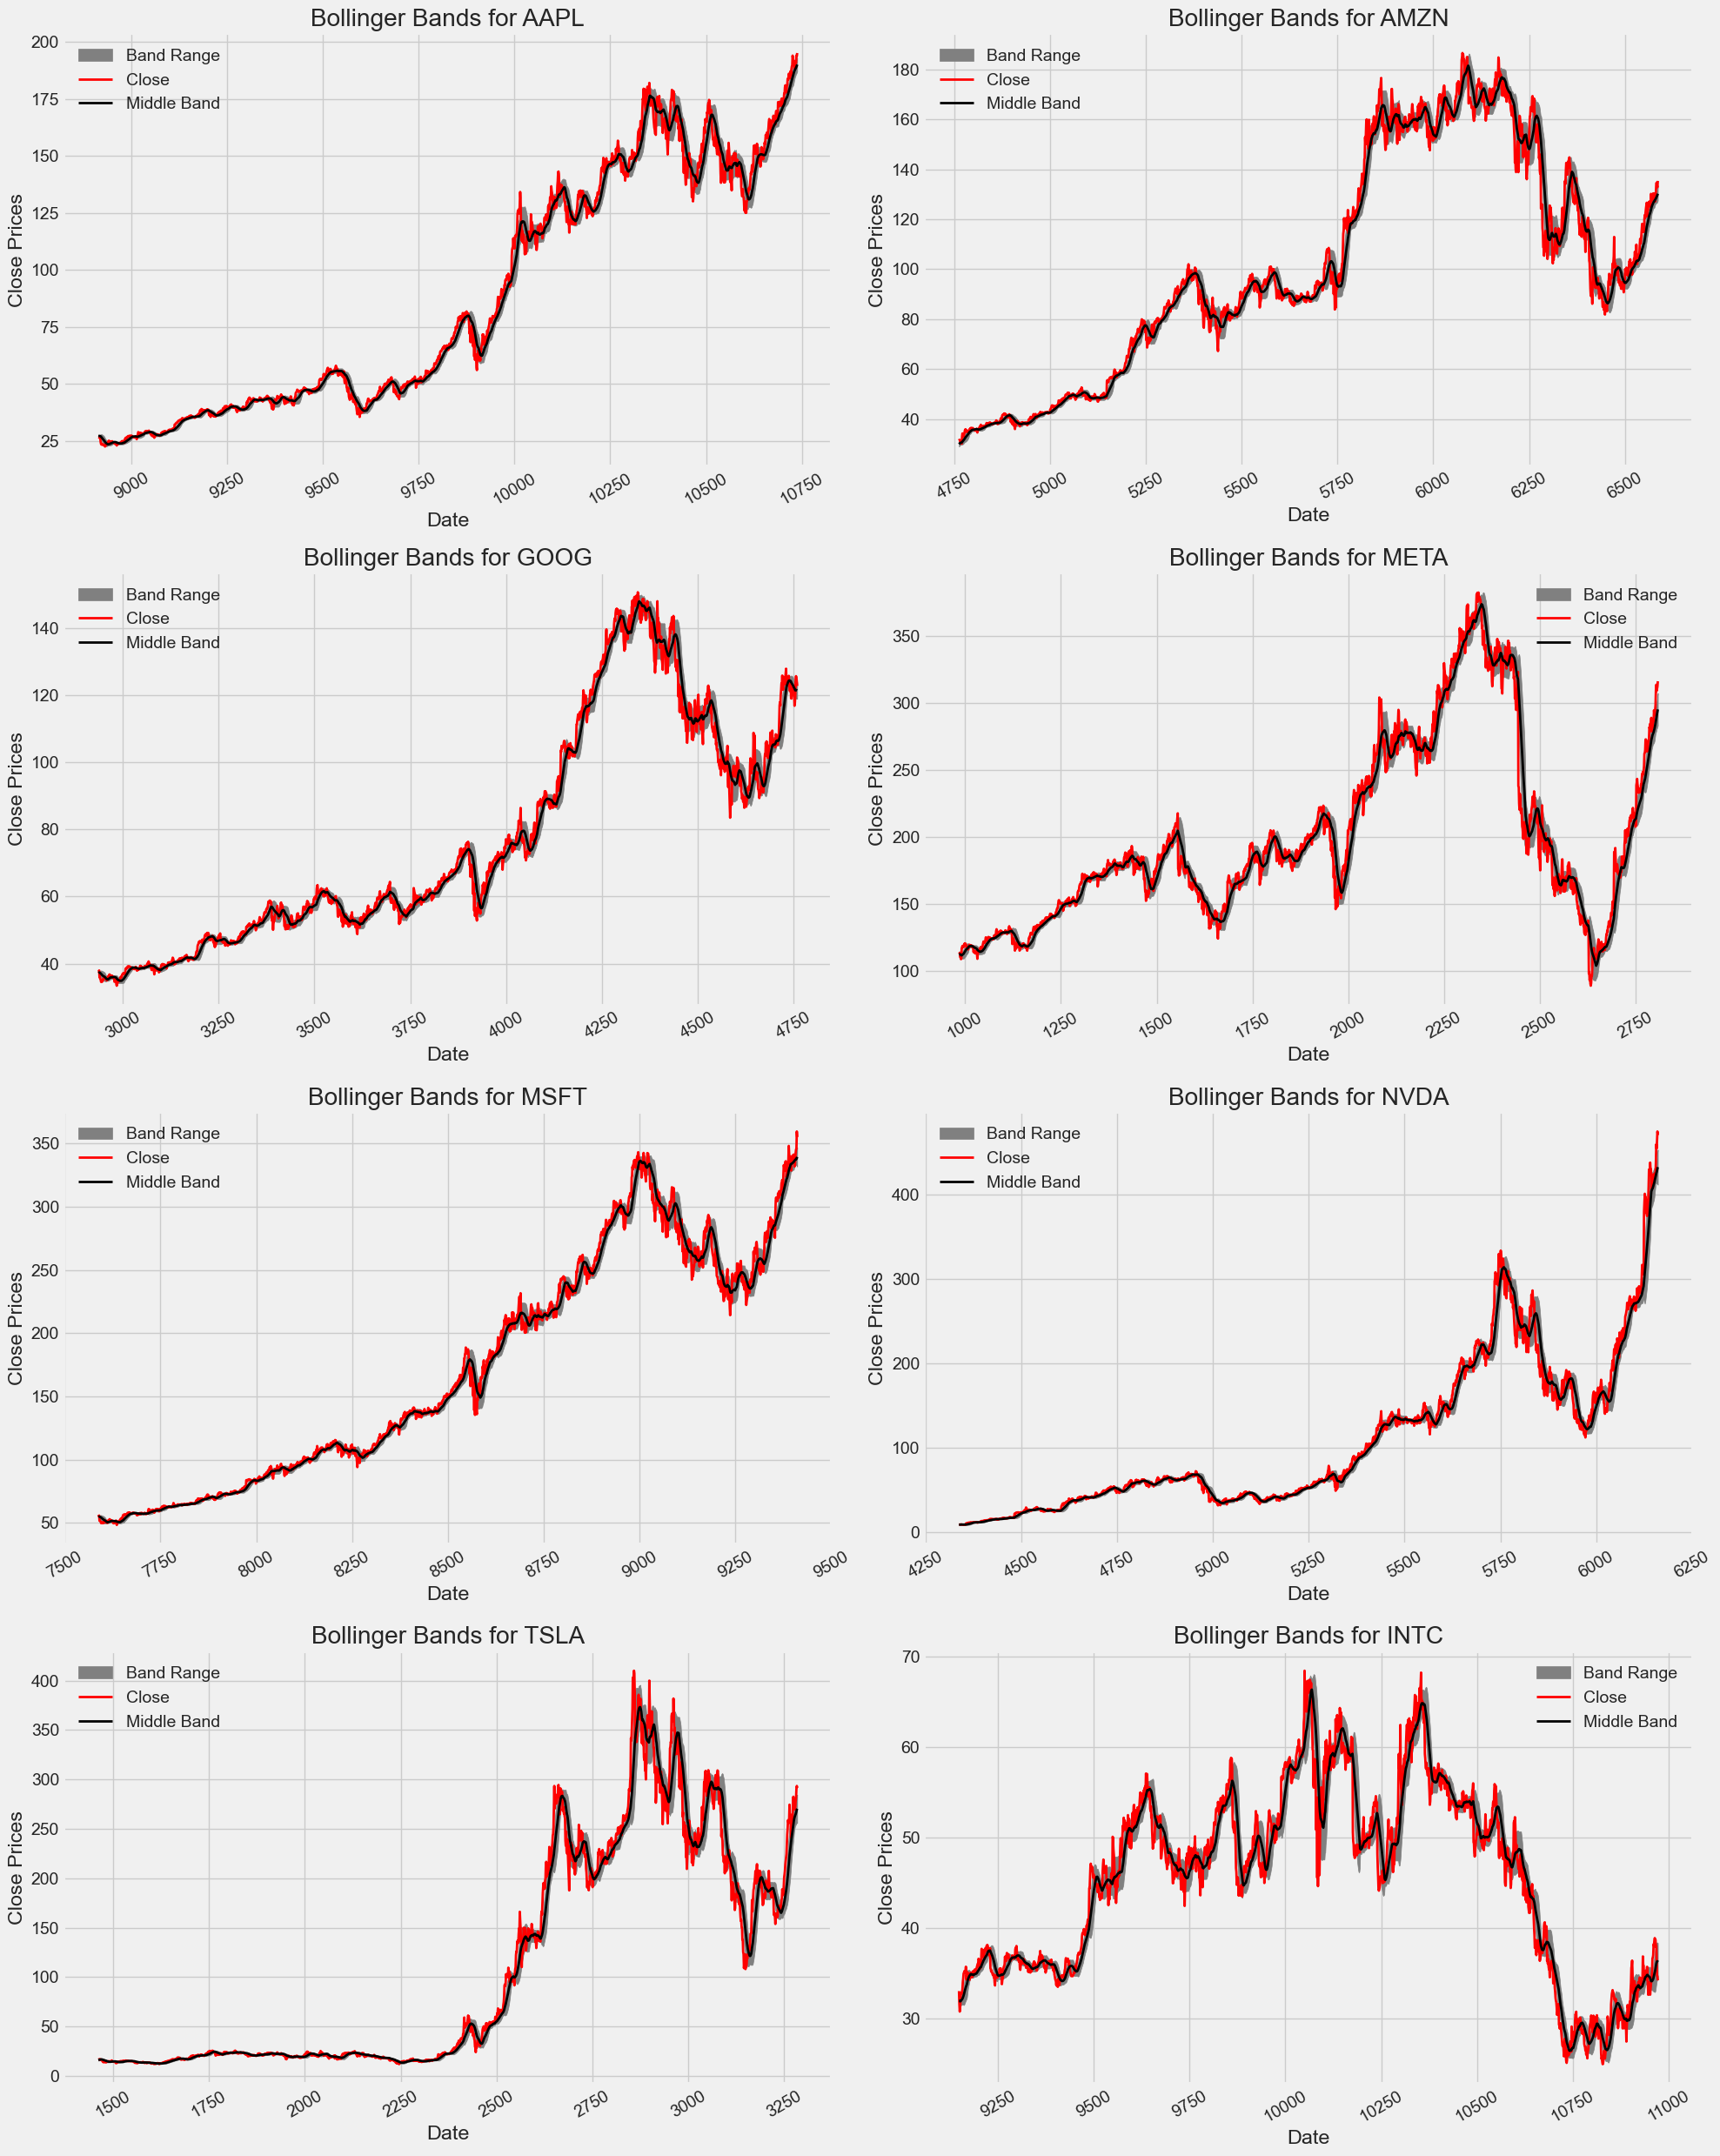

In [239]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.fill_between(TechIndicator[i].index[-1825:], TechIndicator[i]['BB_Upper_Band'][-1825:], TechIndicator[i]['BB_Lower_Band'][-1825:], color='grey', label="Band Range")
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['Close'][-1825:], color='red', lw=2, label="Close")
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['BB_Middle_Band'][-1825:], color='black', lw=2, label="Middle Band")
    ax.set_title("Bollinger Bands for " + str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()
plt.show()


C:\Users\User_Win10x64\AppData\Local\Temp\ipykernel_11732\2690960699.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


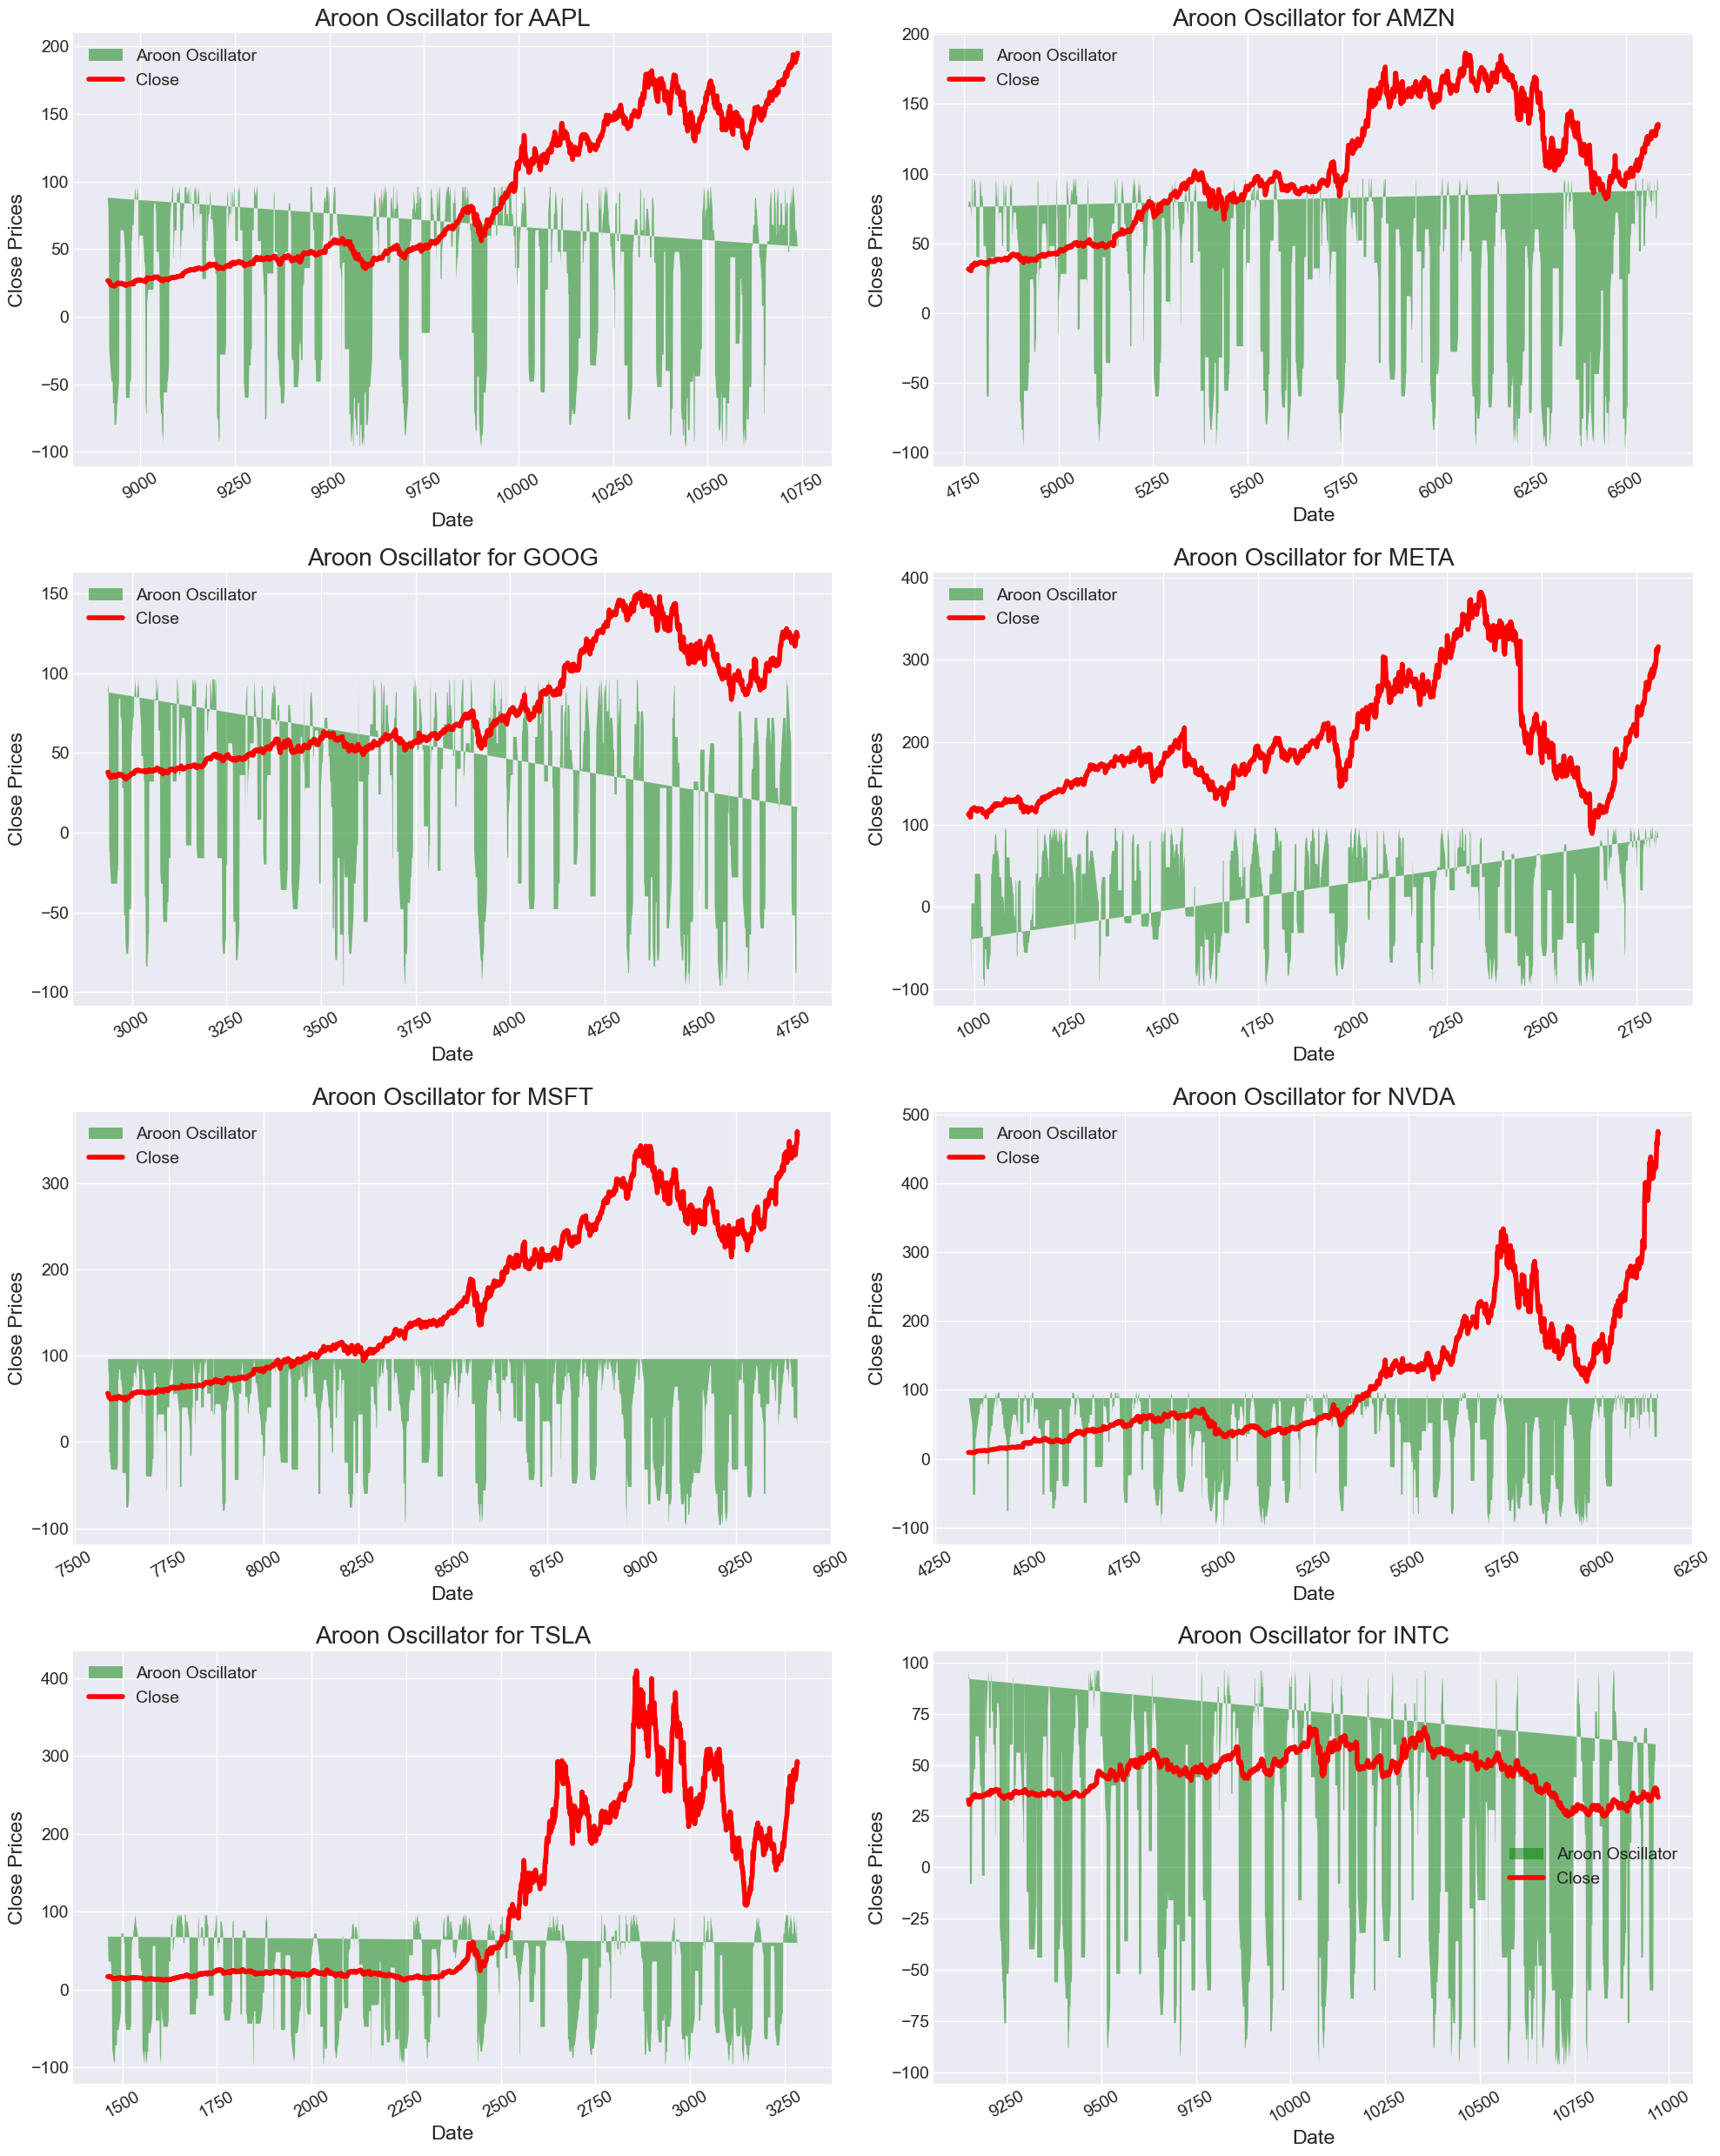

In [240]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.fill(TechIndicator[i].index[-1825:], TechIndicator[i]['Aroon_Oscillator'][-1825:],'g', alpha = 0.5, label = "Aroon Oscillator")
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['Close'][-1825:], 'r', label="Close")
    ax.set_title("Aroon Oscillator for " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

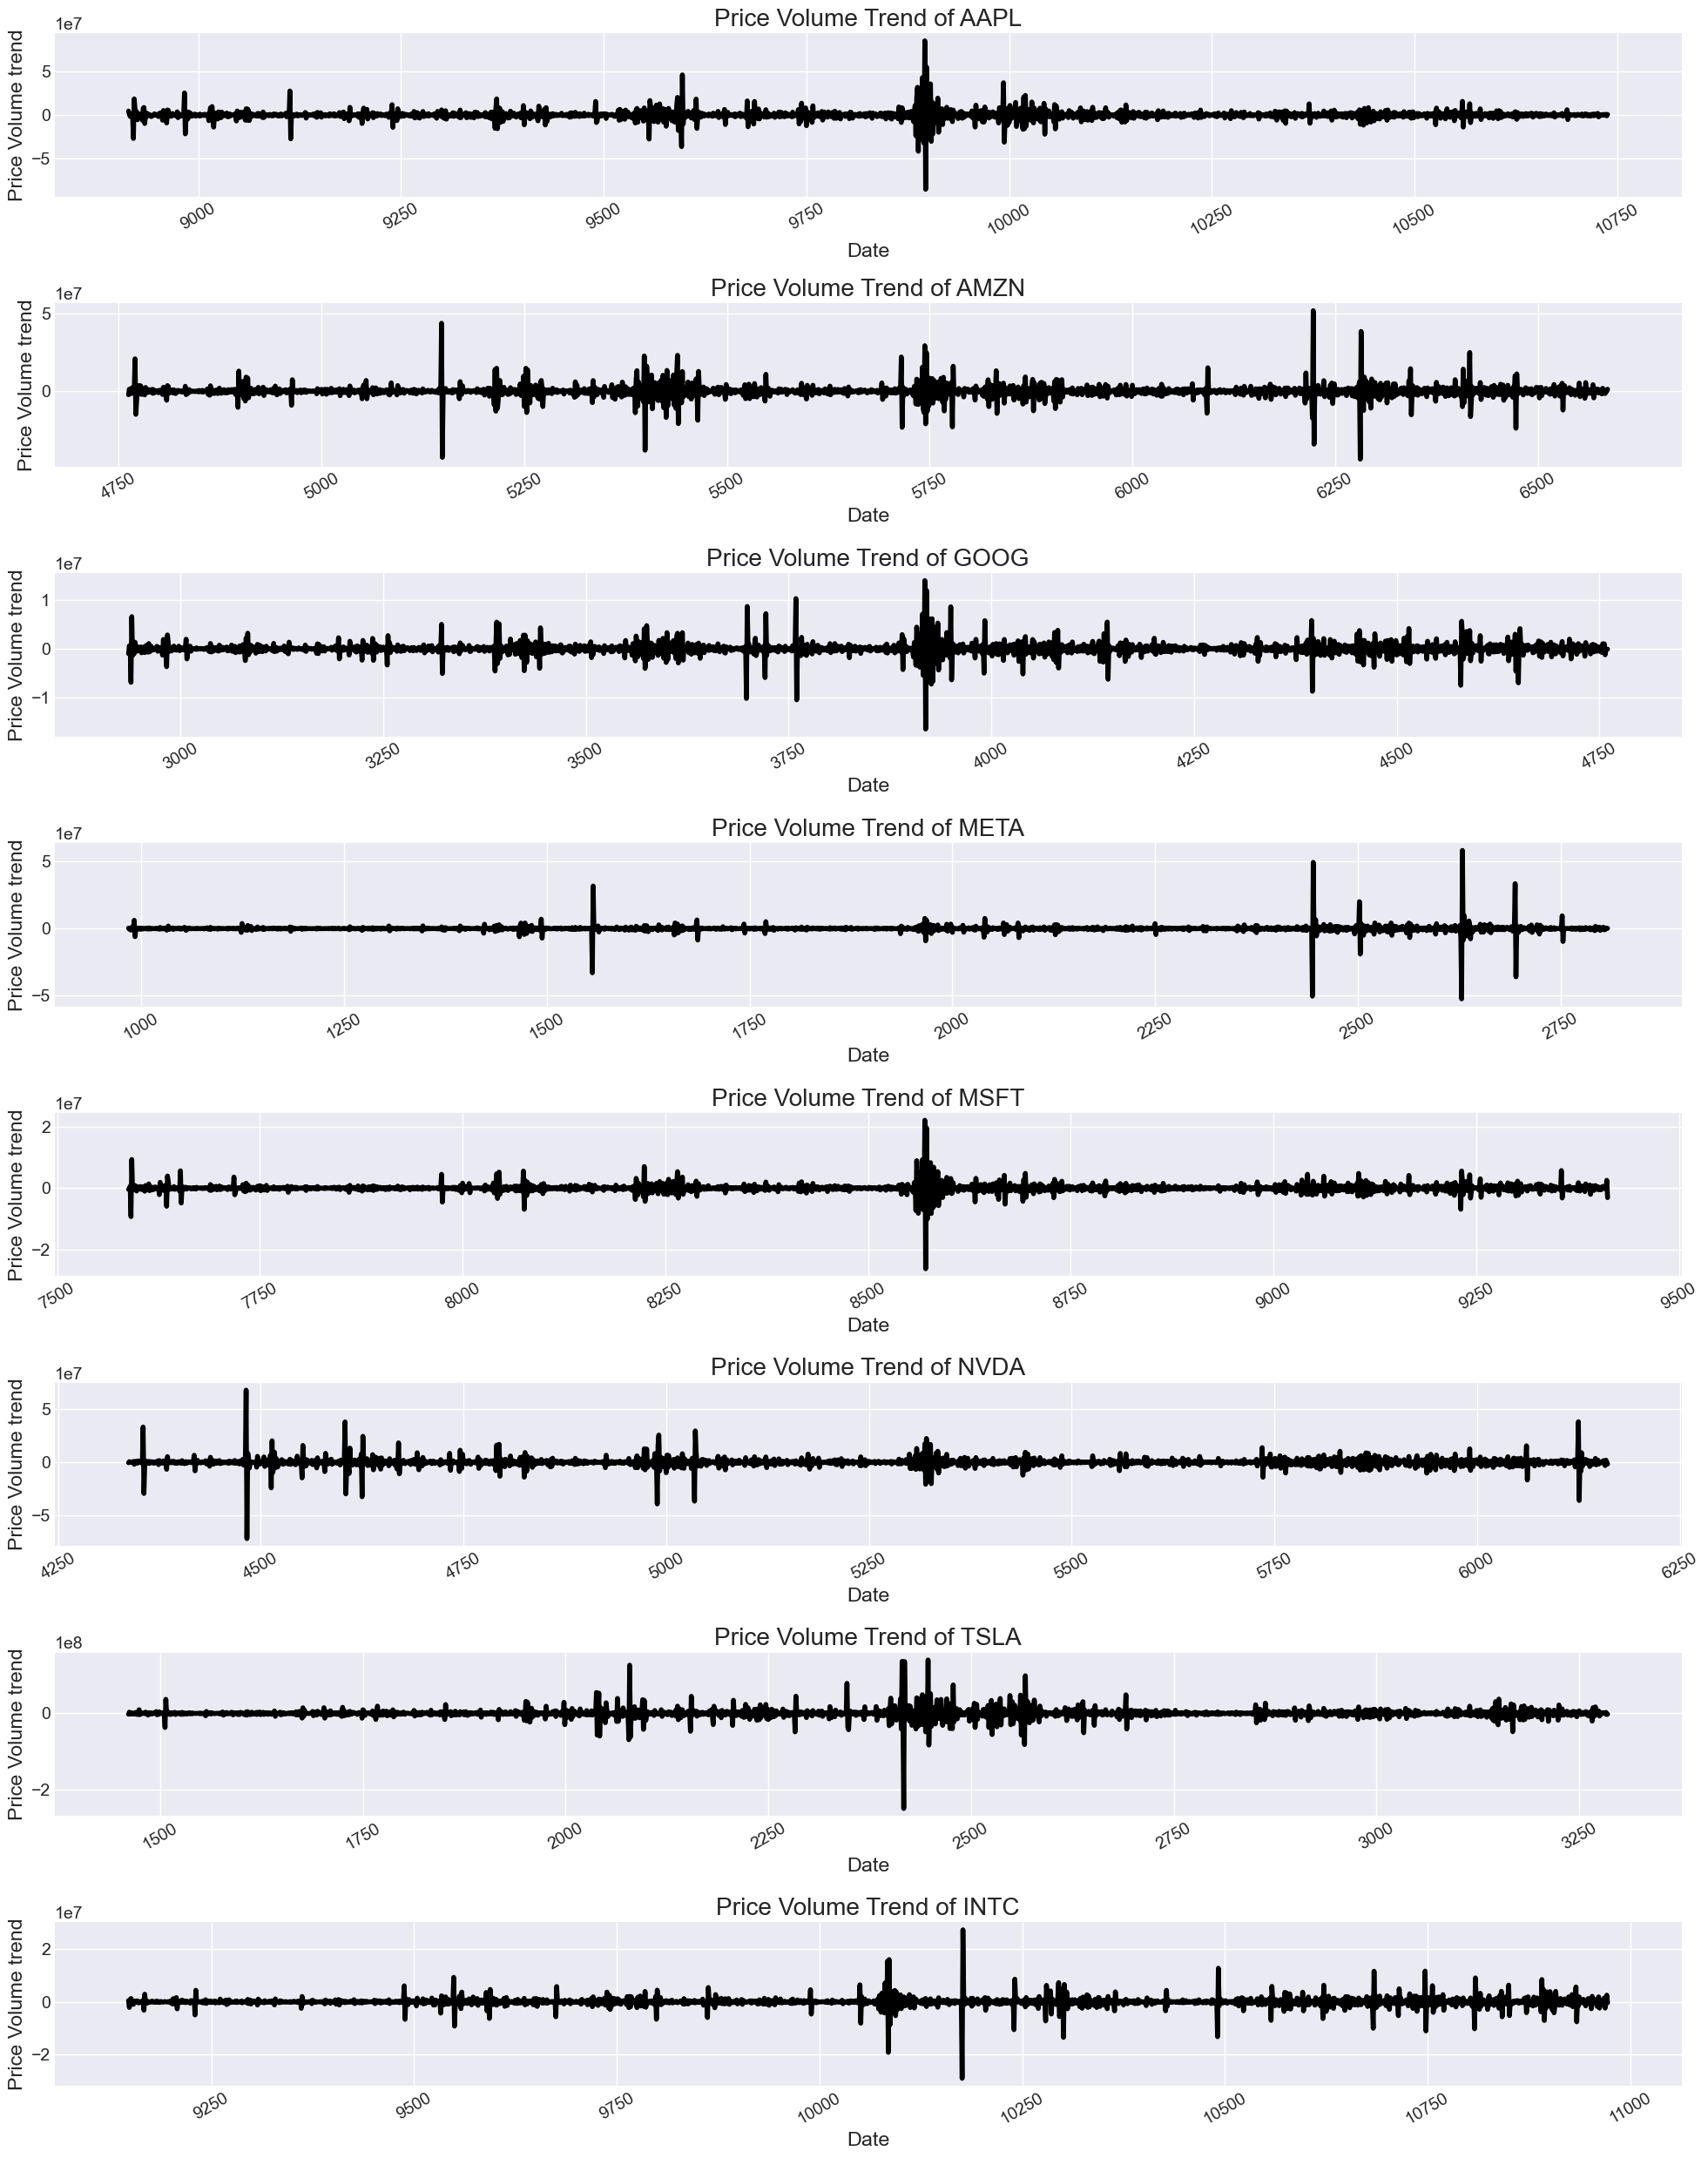

In [241]:
fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(8,1,i+1)
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['PVT'][-1825:], 'black')
    ax.set_title("Price Volume Trend of " +str(TechIndicator[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price Volume trend")
    plt.xticks(rotation=30)
fig.tight_layout()

In [242]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['STOK'][-1825:], 'blue', label="%K")
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['STOD'][-1825:], 'red', label="%D")
    ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['Close'][-1825:], color='black', lw=2, label = "Close")
    ax.set_title("Stochastic Oscillators of " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    plt.xticks(rotation=30)
fig.tight_layout()

C:\Users\User_Win10x64\AppData\Local\Temp\ipykernel_11732\3649063237.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


C:\Users\User_Win10x64\AppData\Local\Temp\ipykernel_11732\2304307808.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


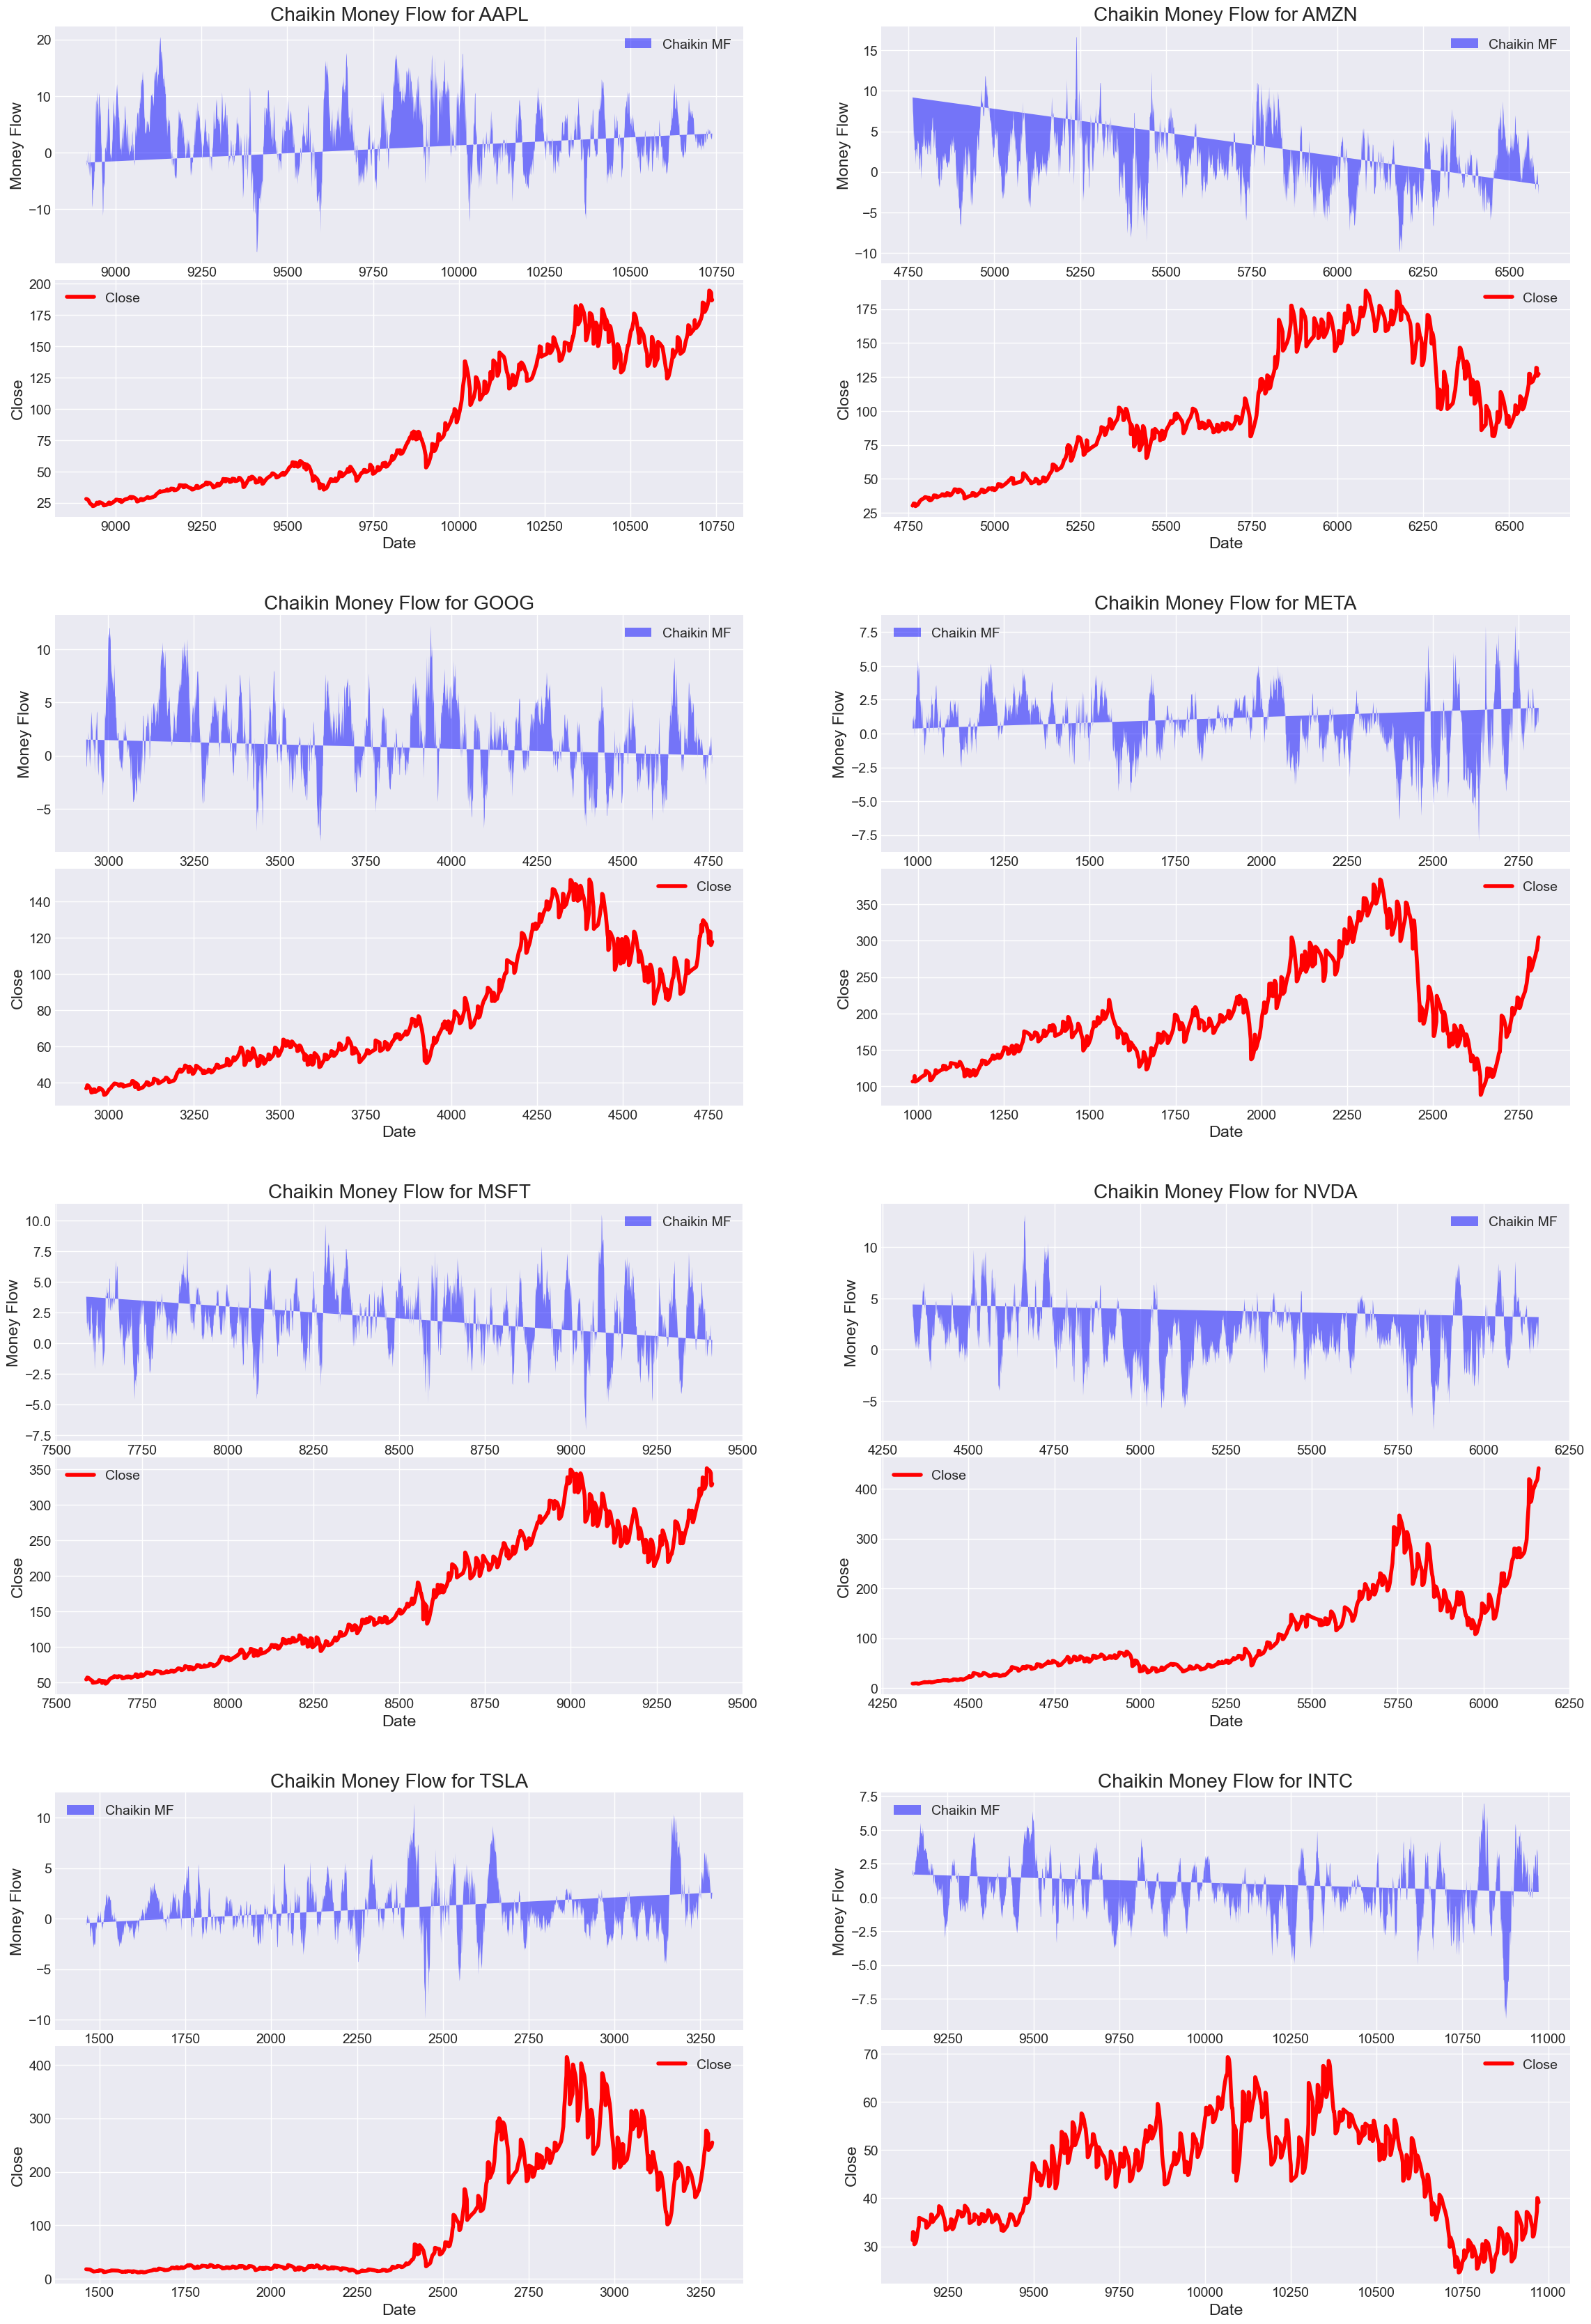

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25,40))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for i in range(8):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.07, hspace=0.07)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j==0:
            t = ax.fill(TechIndicator[i].index[-1825:], TechIndicator[i]['Chaikin_MF'][-1825:],'b', alpha = 0.5, label = "Chaikin MF")
            ax.set_title("Chaikin Money Flow for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("Money Flow")
        else:
            t = ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['Close'][-1825:], 'r', label="Close")
            t = ax.set_ylabel("Close")
        ax.legend()
        ax.set_xlabel("Date")
        
        fig.add_subplot(ax)
fig.tight_layout()

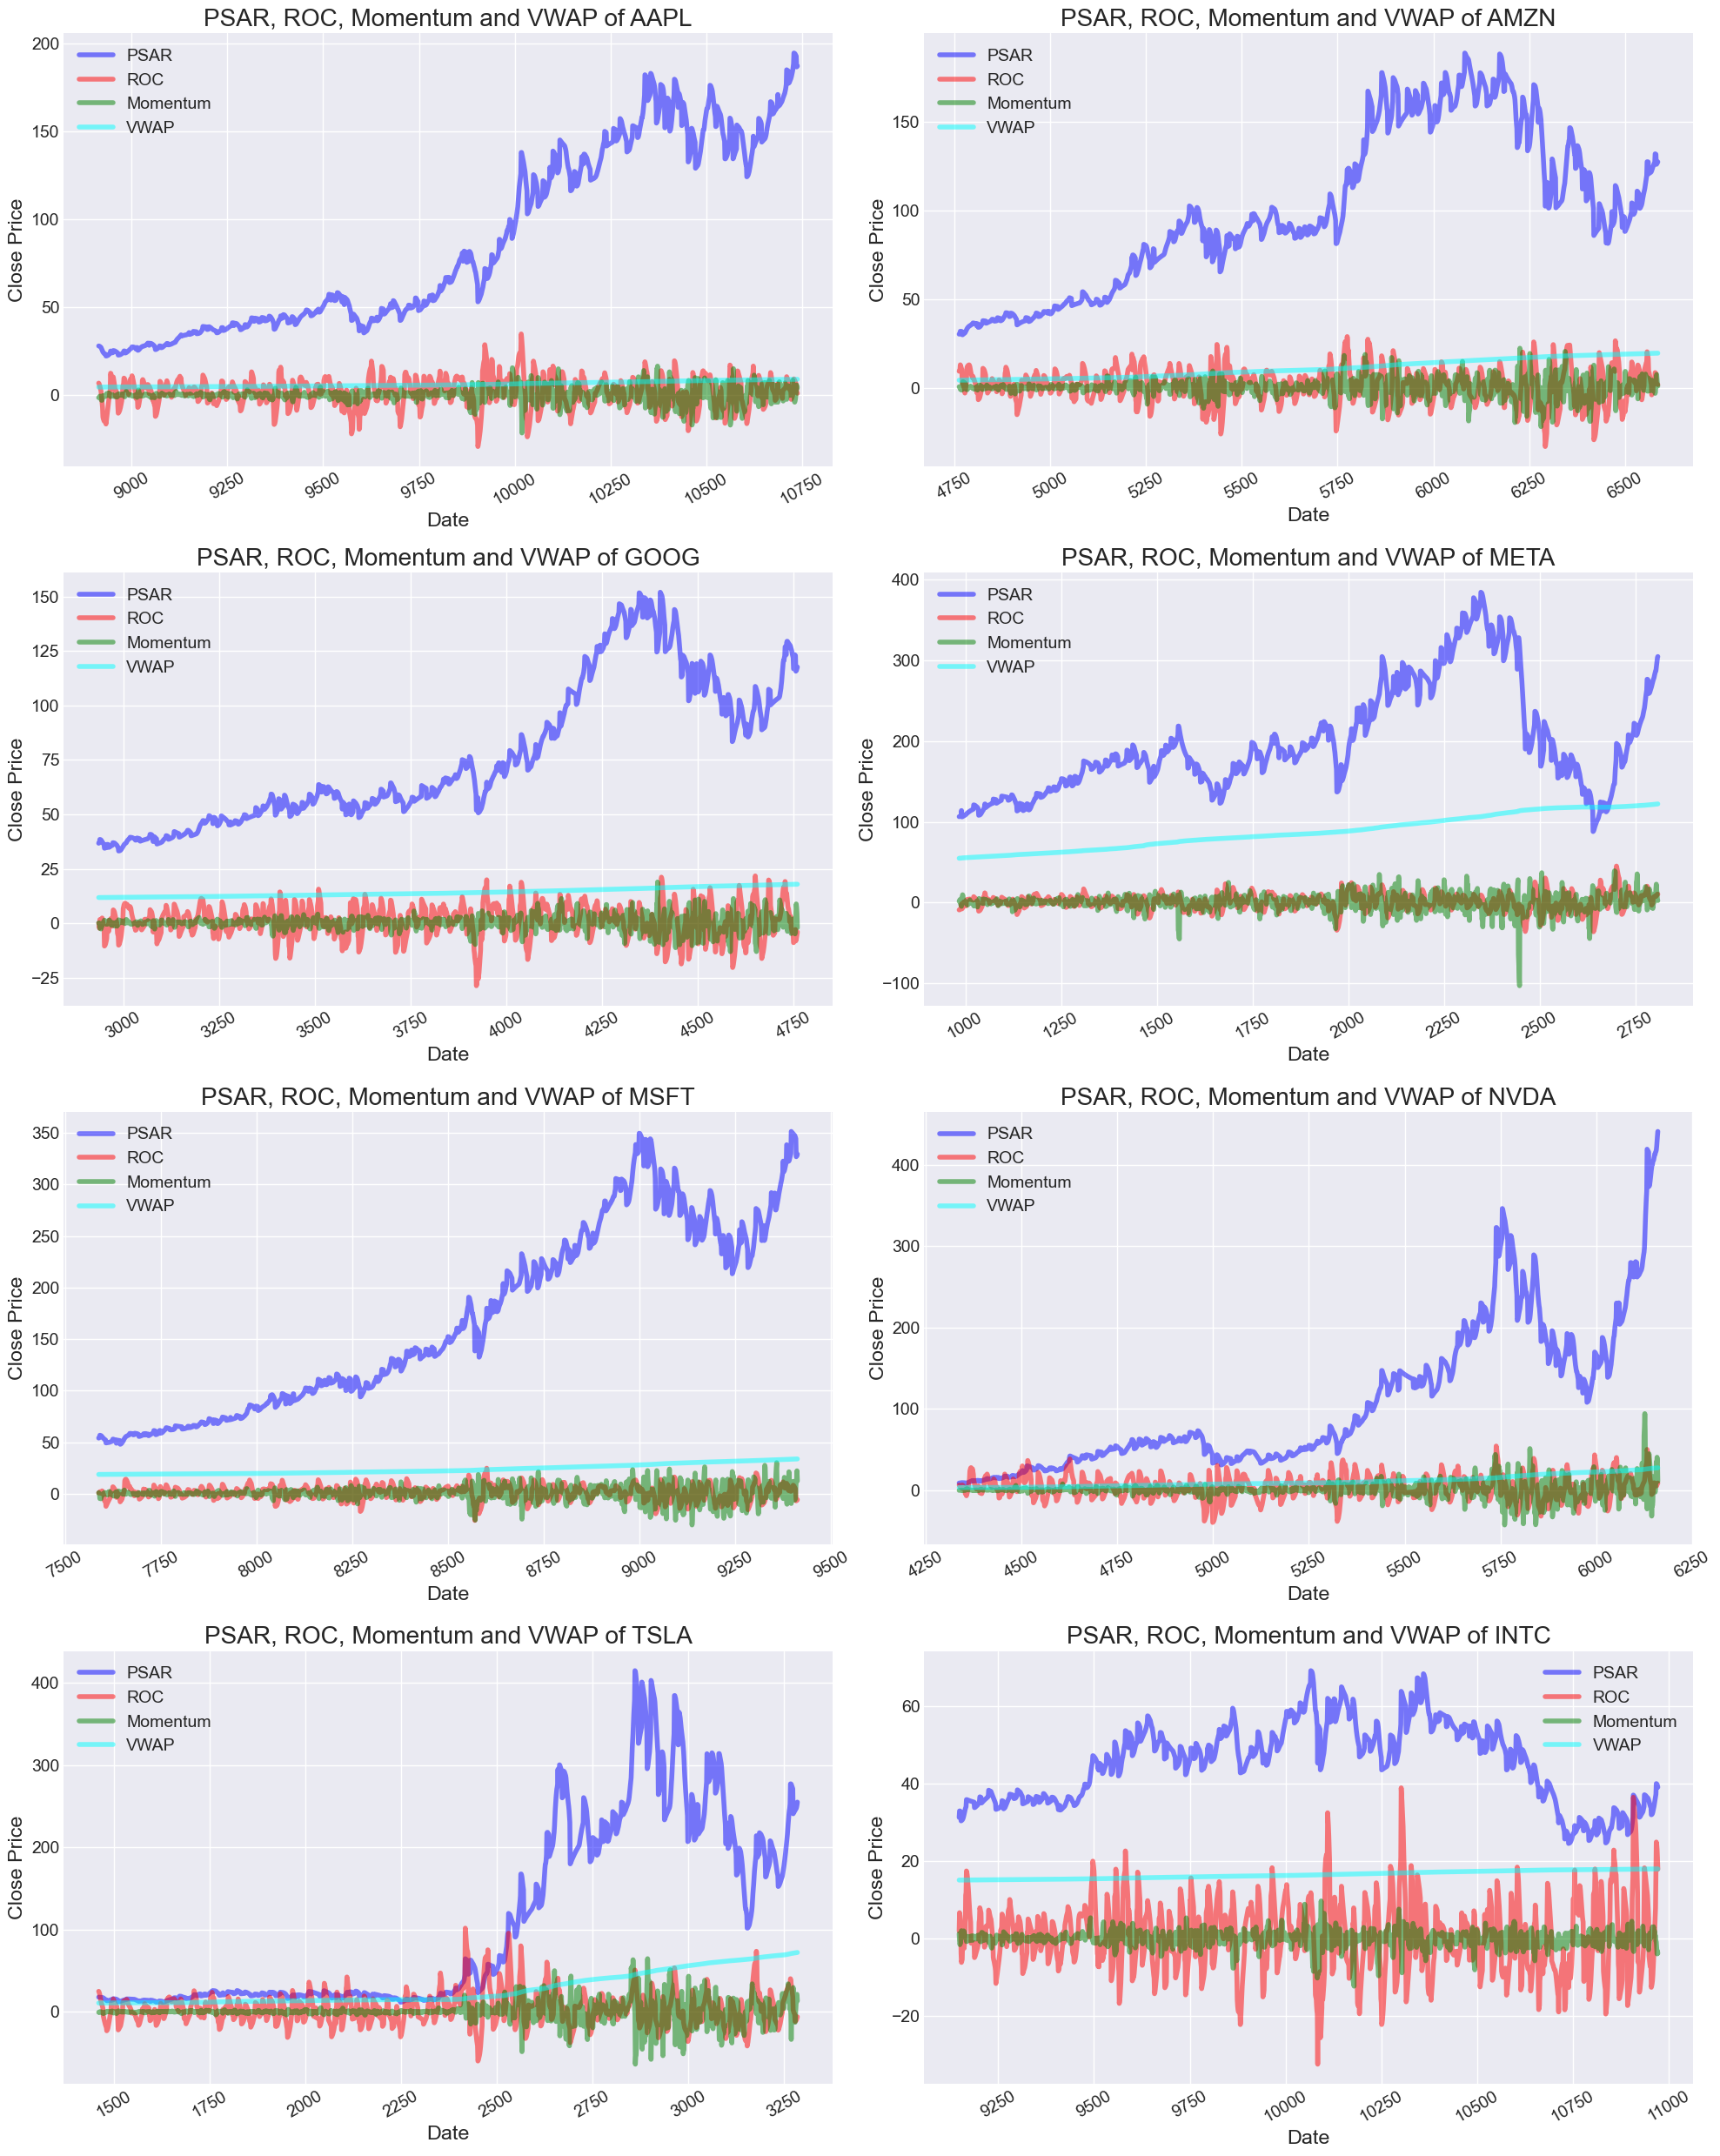

In [ ]:
def calculate_roc(df, n):
    """Calculate the Rate of Change (ROC) and add it as a new column in the DataFrame"""
    close_price = df['Close']  
    roc = ((close_price - close_price.shift(n)) / close_price.shift(n)) * 100
    df['ROC'] = roc

for i in range(8):
    psar(TechIndicator[i])
    calculate_roc(TechIndicator[i], n=12) 

fig = plt.figure(figsize=(20,25))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    
    if 'psar' in TechIndicator[i].columns:
        ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['psar'][-1825:], 'blue', label="PSAR", alpha = 0.5)
    
    if 'ROC' in TechIndicator[i].columns:
        ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['ROC'][-1825:], 'red', label="ROC", alpha = 0.5)
    
    if 'Momentum' in TechIndicator[i].columns:
        ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['Momentum'][-1825:], 'green', label="Momentum", alpha = 0.5)
    
    if 'VWAP' in TechIndicator[i].columns:
        ax.plot(TechIndicator[i].index[-1825:], TechIndicator[i]['VWAP'][-1825:], 'cyan', label="VWAP", alpha = 0.5)
    
    ax.set_title("PSAR, ROC, Momentum and VWAP of " + str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    plt.xticks(rotation=30)
fig.tight_layout()
